In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

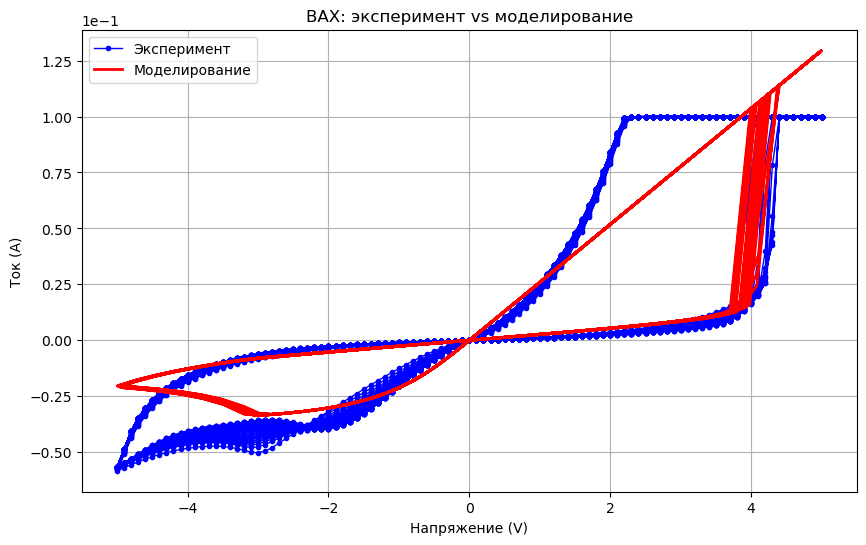

In [ ]:
# Чтение исходных данных
df_exp = pd.read_csv('data/LiNbO3.csv', sep='\t')  
df_exp.columns = ['t', 'v', 'c']

# Чтение результатов моделирования
df_sim = pd.read_csv('memristor_results.csv', sep=',')  
df_sim.columns = ['t', 'V', 'I']

# График ВАХ
plt.figure(figsize=(10, 6))
plt.plot(df_exp['v'], df_exp['c'], 'bo-', linewidth=1, markersize=3, label='Эксперимент')
plt.plot(df_sim['V'], df_sim['I'], 'r-', linewidth=2, label='Моделирование')
plt.xlabel('Напряжение (V)')
plt.ylabel('Ток (A)')
plt.title('ВАХ: эксперимент vs моделирование')
plt.grid(True)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend()
plt.show()